# Analysis on laurel logs

In [1]:
import os
import sys
import numpy as np
import pandas as pd

In [2]:
sys.path.append('../')
sys.path.append('../src/')
sys.path.append('../spell/')

In [3]:
import Reader
import ParamsExtractor3
import DataPreprocessor
import DeepLearningAnomalyDetection2

2024-07-20 08:45:07.822519: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-20 08:45:07.887809: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-20 08:45:08.720032: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Training

In [4]:
log_types = ['laurel']
dates = ['20240418', '20240420', '20240429']
login_node_numbers = ['01', '02', '03', '10']

# Generate the list of file paths
file_paths = [f'/../../../temp_logs/{date}/login{num}.{logtype}.log' for date in dates for num in login_node_numbers for logtype in log_types]

# Filter the list to include only existing files
existing_file_paths = [path for path in file_paths if os.path.exists(path)]
print(existing_file_paths)

df_list = []

for file_path in existing_file_paths:
    r = Reader.Reader(file_path)
    df = r.read_file(file_path)
    df_list.append(df)

['/../../../temp_logs/20240418/login01.laurel.log', '/../../../temp_logs/20240418/login02.laurel.log', '/../../../temp_logs/20240418/login03.laurel.log', '/../../../temp_logs/20240418/login10.laurel.log', '/../../../temp_logs/20240420/login01.laurel.log', '/../../../temp_logs/20240420/login02.laurel.log', '/../../../temp_logs/20240420/login03.laurel.log', '/../../../temp_logs/20240420/login10.laurel.log']


In [5]:
len(df_list)

8

In [6]:
df_after = []

for i, df in enumerate(df_list):
    p = ParamsExtractor3.ParamsExtractor(df)
    df = p.convert_params(df)
    new_df = p.get_params()
    df_after.append(new_df)
    df_list[i] = pd.concat([df_list[i], new_df], axis=1)

In [7]:
df_list[0].head()

host   ident                                            message  \
0  login01  laurel  "1713391196.350:55343008","NODE":"login01","SY...   
1  login01  laurel  "1713391198.212:55343009","NODE":"login01","SY...   
2  login01  laurel  "1713391198.214:55343010","NODE":"login01","SY...   
3  login01  laurel  "1713391198.220:55343011","NODE":"login01","SY...   
4  login01  laurel  "1713391198.221:55343012","NODE":"login01","SY...   

  severity facility                       time  severity_numbers  \
0     info   local6  2024-04-18 00:00:03 +0200                 6   
1     info   local6  2024-04-18 00:00:03 +0200                 6   
2     info   local6  2024-04-18 00:00:03 +0200                 6   
3     info   local6  2024-04-18 00:00:03 +0200                 6   
4     info   local6  2024-04-18 00:00:03 +0200                 6   

   facility_numbers  severity_scores  timedelta    suid  cap_fp      comm  \
0                22              1.0        0.0  126858       0    squeue   
1                22              1.0        0.0       0       0      ping   
2                22              1.0        0.0       0       0  basename   
3                22              1.0        0.0       0       0     egrep   
4                22              1.0        0.0       0       0      grep   

       parent_comm  exit  n_dang  n_dang_no_cron  fp_length  
0             bash     0       2               0         92  
1  pacemaker-execd     0       0               0         38  
2             ping     0       0               0         28  
3             ping     0       0               0         28  
4             ping     0       0               0         21

In [8]:
df_list[0].iloc[0]['message']

'"1713391196.350:55343008","NODE":"login01","SYSCALL":{"arch":"0xc000003e","syscall":59,"success":"yes","exit":0,"items":2,"ppid":29378,"pid":37632,"auid":126858,"uid":126858,"gid":25200,"euid":126858,"suid":126858,"fsuid":126858,"egid":25200,"sgid":25200,"fsgid":25200,"tty":"pts38","ses":703112,"comm":"squeue","exe":"/opt/slurm/23.11.5/bin/squeue","key":"auditcmd","ARCH":"x86_64","SYSCALL":"execve","AUID":"cmatteuc","UID":"cmatteuc","GID":"interactive","EUID":"cmatteuc","SUID":"cmatteuc","FSUID":"cmatteuc","EGID":"interactive","SGID":"interactive","FSGID":"interactive","ARGV":["0x564021c6aff0","0x564021c6bdf0","0x564021c34470","0x8"]},"EXECVE":{"argc":3,"ARGV":["squeue","-u","cmatteuc"],"ENV":{"LD_LIBRARY_PATH":"/g100_work/PROJECTS/spack/v0.17/prod/0.17.1/install/0.17/linux-centos8-skylake_avx512/gcc-8.4.1/anaconda3-2021.05-alnfpd33vtv6tt7sf6iq5ngwv7nqgeah/lib:/cineca/prod/opt/compilers/intel/oneapi-2022/binary/mpi/latest/libfabric/lib/prov:/cineca/prod/opt/compilers/intel/oneapi-2022

In [9]:
for i, df in enumerate(df_list):
    d = DataPreprocessor.DataPreprocessor(df)
    enc = d.drop_and_hash_encode()
    df_list[i] = enc

print(df_list[0].head())

   severity_scores  timedelta    suid  cap_fp      comm      parent_comm  \
0              1.0        0.0  126858       0    squeue             bash   
1              1.0        0.0       0       0      ping  pacemaker-execd   
2              1.0        0.0       0       0  basename             ping   
3              1.0        0.0       0       0     egrep             ping   
4              1.0        0.0       0       0      grep             ping   

   exit  n_dang  n_dang_no_cron  fp_length  ...  col_10  col_11  col_12  \
0     0       2               0         92  ...       0       0       0   
1     0       0               0         38  ...       0       0       0   
2     0       0               0         28  ...       0       0       0   
3     0       0               0         28  ...       0       0       0   
4     0       0               0         21  ...       0       0       0   

   col_13  col_14  col_15  col_16  col_17  col_18  col_19  
0       0       0       0       

In [10]:
for df in df_list:
    print(df.shape)

(1000, 30)
(1000, 30)
(1000, 30)
(1000, 30)
(1000, 30)
(1000, 30)
(1000, 30)
(1000, 30)


In [11]:
normal_dataset = df_list[0]

for i in range(1,len(df_list)):
    normal_dataset = np.vstack([normal_dataset, df_list[i]])

In [12]:
normal_dataset.shape

(8000, 30)

## Anomalies' dataset

In [17]:
log_types = ['laurel']

# Generate the list of file paths
file_paths = [f'../data/new_laurel_conf/audit.log' for logtype in log_types]

# Filter the list to include only existing files
existing_file_paths = [path for path in file_paths if os.path.exists(path)]
print(existing_file_paths)

an_df_list = []

for file_path in existing_file_paths:
    r = Reader.Reader(file_path)
    df = r.read_file(file_path)
    print(df.head())
    #df.columns = ['hostname', 'ident', 'message', 'severity', 'facility', 'time']
    an_df_list.append(df)

['../data/new_laurel_conf/audit.log']
                   ID                                            SYSCALL  \
0  1721464625.772:929  {'arch': '0xc000003e', 'syscall': 59, 'success...   
1  1721464625.816:930  {'arch': '0xc000003e', 'syscall': 59, 'success...   
2  1721464625.641:933  {'arch': '0xc000003e', 'syscall': 59, 'success...   
3  1721464625.512:934  {'arch': '0xc000003e', 'syscall': 59, 'success...   
4  1721464625.636:935  {'arch': '0xc000003e', 'syscall': 59, 'success...   

                                              EXECVE                      CWD  \
0  {'argc': 5, 'ARGV': ['/usr/bin/pkla-check-auth...             {'cwd': '/'}   
1  {'argc': 5, 'ARGV': ['/usr/bin/pkla-check-auth...             {'cwd': '/'}   
2  {'argc': 1, 'ARGV': ['/usr/libexec/gsd-rfkill'...  {'cwd': '/var/lib/gdm'}   
3  {'argc': 1, 'ARGV': ['/usr/libexec/gsd-sharing...  {'cwd': '/var/lib/gdm'}   
4  {'argc': 1, 'ARGV': ['/usr/libexec/gsd-keyboar...  {'cwd': '/var/lib/gdm'}   

                  

In [18]:
an_df_list[0].head()

ID                                            SYSCALL  \
0  1721464625.772:929  {'arch': '0xc000003e', 'syscall': 59, 'success...   
1  1721464625.816:930  {'arch': '0xc000003e', 'syscall': 59, 'success...   
2  1721464625.641:933  {'arch': '0xc000003e', 'syscall': 59, 'success...   
3  1721464625.512:934  {'arch': '0xc000003e', 'syscall': 59, 'success...   
4  1721464625.636:935  {'arch': '0xc000003e', 'syscall': 59, 'success...   

                                              EXECVE                      CWD  \
0  {'argc': 5, 'ARGV': ['/usr/bin/pkla-check-auth...             {'cwd': '/'}   
1  {'argc': 5, 'ARGV': ['/usr/bin/pkla-check-auth...             {'cwd': '/'}   
2  {'argc': 1, 'ARGV': ['/usr/libexec/gsd-rfkill'...  {'cwd': '/var/lib/gdm'}   
3  {'argc': 1, 'ARGV': ['/usr/libexec/gsd-sharing...  {'cwd': '/var/lib/gdm'}   
4  {'argc': 1, 'ARGV': ['/usr/libexec/gsd-keyboar...  {'cwd': '/var/lib/gdm'}   

                                                PATH  \
0  [{'item': 0, 'name': '/usr/bin/pkla-check-auth...   
1  [{'item': 0, 'name': '/usr/bin/pkla-check-auth...   
2  [{'item': 0, 'name': '/usr/libexec/gsd-rfkill'...   
3  [{'item': 0, 'name': '/usr/libexec/gsd-sharing...   
4  [{'item': 0, 'name': '/usr/libexec/gsd-keyboar...   

                                           PROCTITLE SERVICE_STOP BPRM_FCAPS  \
0  {'ARGV': ['/usr/bin/pkla-check-authorization',...          NaN        NaN   
1  {'ARGV': ['/usr/bin/pkla-check-authorization',...          NaN        NaN   
2  {'ARGV': ['/bin/sh', '-e', '-u', '-c', 'export...          NaN        NaN   
3  {'ARGV': ['/bin/sh', '-e', '-u', '-c', 'export...          NaN        NaN   
4  {'ARGV': ['/bin/sh', '-e', '-u', '-c', 'export...          NaN        NaN   

  SERVICE_START SYSTEM_RUNLEVEL  ... USER_AUTH USER_ACCT CRED_ACQ LOGIN  \
0           NaN             NaN  ...       NaN       NaN      NaN   NaN   
1           NaN             NaN  ...       NaN       NaN      NaN   NaN   
2           NaN             NaN  ...       NaN       NaN      NaN   NaN   
3           NaN             NaN  ...       NaN       NaN      NaN   NaN   
4           NaN             NaN  ...       NaN       NaN      NaN   NaN   

  USER_ROLE_CHANGE USER_START USER_END CRED_DISP USER_CMD CRED_REFR  
0              NaN        NaN      NaN       NaN      NaN       NaN  
1              NaN        NaN      NaN       NaN      NaN       NaN  
2              NaN        NaN      NaN       NaN      NaN       NaN  
3              NaN        NaN      NaN       NaN      NaN       NaN  
4              NaN        NaN      NaN       NaN      NaN       NaN  

[5 rows x 21 columns]

In [25]:
an_df_list[0].columns

Index(['ID', 'SYSCALL', 'EXECVE', 'CWD', 'PATH', 'PROCTITLE', 'SERVICE_STOP',
       'BPRM_FCAPS', 'SERVICE_START', 'SYSTEM_RUNLEVEL', 'BPF', 'USER_AUTH',
       'USER_ACCT', 'CRED_ACQ', 'LOGIN', 'USER_ROLE_CHANGE', 'USER_START',
       'USER_END', 'CRED_DISP', 'USER_CMD', 'CRED_REFR'],
      dtype='object')

In [27]:
suid, cap_fp, comm, parent_comm, exit = -1,-1,-1,-1,-1

try:
    suid = an_df_list[0]['SYSCALL'].iloc[0]['suid']
except:
    pass

try:
    comm = an_df_list[0]['SYSCALL'].iloc[0]['comm']
except:
    pass

try:
    exit = an_df_list[0]['SYSCALL'].iloc[0]['exit']
except:
    pass

try:
    cap_fp = an_df_list[0]['PATH'].iloc[0][0]['cap_fp']
    cap_fp = int(cap_fp, 0)
except:
    pass

try:
    parent_comm = an_df_list[0]['PARENT_INFO'].iloc[0]['comm']
except:
    pass

params = [suid, cap_fp, comm, parent_comm, exit]
print(params)

[998, 0, 'pkla-check-auth', -1, 0]


In [31]:
an_df_list[0].iloc[0]['PATH'][0]['cap_fp']

'0x0'

In [59]:
def get_params_from_line(line):
    suid, cap_fp, comm, parent_comm, exit = -1,-1,-1,-1,-1

    #print(line[1]['SYSCALL'])
    #print('============')

    line = line[1]

    try:
        suid = line['SYSCALL']['suid']
    except:
        pass
    
    try:
        comm = line['SYSCALL']['comm']
    except:
        pass
    
    try:
        exit = line['SYSCALL']['exit']
    except:
        pass
    
    try:
        cap_fp = line['PATH'][0]['cap_fp']
        cap_fp = int(cap_fp, 0)
    except:
        pass
    
    try:
        parent_comm = line['PARENT_INFO']['comm']
    except:
        pass
    
    params = [suid, cap_fp, comm, parent_comm, exit, -1, 0, 0, 0]
    #print(params)
    return params

In [60]:
data_list = []
for line in an_df_list[0].iterrows():
    params = get_params_from_line(line)
    data_list.append(params)

an_df = pd.DataFrame(data_list)
an_df.columns = ['suid', 'cap_fp', 'comm', 'parent_comm', 'exit', 'log key', 'n_dang', 'n_dang_no_cron', 'fp_length']

In [61]:
an_df.head()

suid  cap_fp             comm  parent_comm  exit  log key  n_dang  \
0   998       0  pkla-check-auth           -1     0       -1       0   
1   998       0  pkla-check-auth           -1     0       -1       0   
2    42       0       gsd-rfkill           -1     0       -1       0   
3    42       0      gsd-sharing           -1     0       -1       0   
4    42       0     gsd-keyboard           -1     0       -1       0   

   n_dang_no_cron  fp_length  
0               0          0  
1               0          0  
2               0          0  
3               0          0  
4               0          0

In [63]:
import LaurelParamsExtractor

In [ ]:
an_df_after = []

for i, df in enumerate(an_df_list):
    p = ParamsExtractor3.ParamsExtractor(df)
    df = p.convert_params(df)
    l = LaurelParamsExtractor.LaurelParamsExtractor()
    new_df = l.get_params(df)
    an_df_after.append(new_df)
    an_df_list[i] = pd.concat([an_df_list[i], new_df], axis=1)

In [ ]:
an_df_list[0].head()

In [ ]:
for i, df in enumerate(an_df_list):
    d = DataPreprocessor.DataPreprocessor(df)
    enc = d.drop_and_hash_encode()
    an_df_list[i] = enc

print(an_df_list[0].head())

In [ ]:
# we test secure
# we take the lines from the 230th (detected pwd bruteforcing)
anomalous_dataset = an_df_list[0][230:]

In [ ]:
anomalous_dataset.shape

In [ ]:
anomalous_dataset.columns

In [ ]:
df_list[0].columns

In [ ]:
for i, df in enumerate(df_list):
    df_list[i] = df.drop(['cap_fp', 'parent_comm', 'n_dang', 'n_dang_no_cron', 'fp_length', 'col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7', 'col_8', 'col_9','col_10', 'col_11', 'col_12', 'col_13', 'col_14', 'col_15', 'col_16','col_17', 'col_18', 'col_19'], axis=1)

In [ ]:
anomalous_dataset = anomalous_dataset.drop(['hostname', 'col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7', 'col_8', 'col_9','col_10', 'col_11', 'col_12', 'col_13', 'col_14', 'col_15', 'col_16','col_17', 'col_18', 'col_19'], axis=1)

In [ ]:
df_list[0].columns

In [ ]:
anomalous_dataset.columns

In [ ]:
df_list[0].head()

In [64]:
import EncodeCommand
encoder = EncodeCommand.EncodeCommand()

In [ ]:
for i, df in enumerate(df_list):
    df_encoded = encoder.encode_command(df)
    df_list[i] = df_encoded

print(df_list[0].head())

In [ ]:
for i, df in enumerate(an_df_list):
    df_encoded = encoder.encode_command(df)
    an_df_list[i] = df_encoded

print(an_df_list[0].head())

In [ ]:
anomalous_dataset_encoded = encoder.encode_command(anomalous_dataset)

In [65]:
anomalous_dataset_encoded = encoder.encode_command(an_df)

In [66]:
anomalous_dataset_encoded.head()

suid  cap_fp             comm  parent_comm  exit  log key  n_dang  \
0   998       0  pkla-check-auth           -1     0       -1       0   
1   998       0  pkla-check-auth           -1     0       -1       0   
2    42       0       gsd-rfkill           -1     0       -1       0   
3    42       0      gsd-sharing           -1     0       -1       0   
4    42       0     gsd-keyboard           -1     0       -1       0   

   n_dang_no_cron  fp_length  enc_comm  
0               0          0         1  
1               0          0         1  
2               0          0         2  
3               0          0         3  
4               0          0         4

In [67]:
anomalous_dataset_encoded.columns

Index(['suid', 'cap_fp', 'comm', 'parent_comm', 'exit', 'log key', 'n_dang',
       'n_dang_no_cron', 'fp_length', 'enc_comm'],
      dtype='object')

## Library implementation

In [68]:
normal_dataset_df = pd.DataFrame(df_list[0], columns=['severity_scores', 'timedelta', 'suid', 'exit', 'enc_comm'])
anomalous_dataset_df = pd.DataFrame(anomalous_dataset_encoded, columns=['severity_scores', 'timedelta', 'suid', 'exit', 'enc_comm'])

/home/rocky/.local/lib/python3.9/site-packages/sklearn/utils/_array_api.py:472: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/home/rocky/.local/lib/python3.9/site-packages/sklearn/utils/_array_api.py:489: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


Mean normal reconstruction error: nan
Mean anomalous reconstruction error: nan


/home/rocky/.local/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6834: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/home/rocky/.local/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6835: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: Data has no positive values, and therefore cannot be log-scaled.

<Figure size 1000x600 with 1 Axes>

Threshold for anomaly detection: nan
Number of anomalies detected: 0
Number of false positives detected: 0


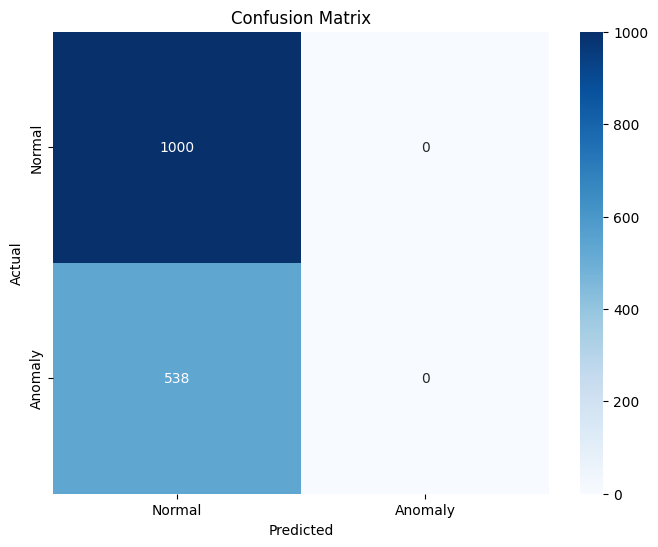

In [69]:
d_an_det = DeepLearningAnomalyDetection2.DeepLearningAnomalyDetection()
true_anomalies, reconstructed_anomalies, fp_ = d_an_det.train_test_model(normal_dataset_df, anomalous_dataset_df, 'autoencoder', laurel=1, plots=[0,0,1,1])

In [ ]:
d_an_det = DeepLearningAnomalyDetection2.DeepLearningAnomalyDetection()
true_anomalies_vae, reconstructed_anomalies_vae, fp = d_an_det.train_test_model(normal_dataset_df, anomalous_dataset_df, 'vae', laurel=1, plots=[0,0,1,1])

In [ ]:
d_an_det.ensemble_method(normal_dataset_df, anomalous_dataset, plots=[1])

In [ ]:
# Example predictions from two models (replace with your actual predictions)
predictions_model1 = reconstructed_anomalies
predictions_model2 = reconstructed_anomalies_vae

# Combine predictions using logical OR (voting scheme)
combined_predictions = np.logical_and(predictions_model1, predictions_model2).astype(int)

# Example thresholding (adjust as needed)
threshold = 0.5  # Simple majority voting

# Convert to final anomaly predictions based on threshold
final_predictions = (combined_predictions >= threshold).astype(int)

# Print or use the final predictions
print("Combined Predictions:", combined_predictions)
print("Final Anomaly Predictions:", final_predictions)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Example ground truth and predictions (replace with your actual data)
ground_truth = true_anomalies
predictions = final_predictions
            
# Calculate confusion matrix
cm = confusion_matrix(ground_truth, predictions)
            
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                        xticklabels=['Normal', 'Anomaly'], 
                        yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()